# Template Notebook for testing an Island Model GA with artists on an island
Notebook Version: 0.2 (01/03/2024)

In [3]:
from evolutionary.plotting import plot_fitness_statistics
from diffusers.utils import logging
from evolutionary_imaging.processing import create_animation_from_generations, create_generation_image_grid, save_images_from_generation
from datetime import datetime
import torch
import os

In [4]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems
os.environ["TOKENIZERS_PARALLELISM"] = "false" # To remove warning of libraries using tokenizers

def save_images_post_evaluation(g, a):
    now = datetime.now()
    time_str = now.strftime("%H%M%S") # append a timestring to avoid overlapping of different GAs when saving images
    save_images_from_generation(a.population, g, time_str)
    
# Check torch random state, used across all libraries. Caution setting fixed seeds as it affects not only generation but also variation.
print(torch.random.get_rng_state())

tensor([ 15,  12, 233,  ...,   0,   0,   0], dtype=torch.uint8)


In [5]:
from evolutionary_prompt_embedding.argument_types import PooledPromptEmbedData
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary_prompt_embedding.variation import \
    UniformGaussianMutatorArguments, PooledUniformGaussianMutator, PooledArithmeticCrossover, PooledUniformCrossover
from evolutionary_prompt_embedding.value_ranges import SDXLTurboEmbeddingRange, SDXLTurboPooledEmbeddingRange
from evolutionary.evolutionary_selectors import TournamentSelector, RouletteWheelSelector, RankSelector
from evolutionary.algorithms.island_model import IslandModel
from evolutionary.algorithms.ga import GeneticAlgorithm
from evolutionary_imaging.evaluators import AIDetectionImageEvaluator

population_size = 10
num_generations = 150
batch_size = 1
elitism = None
inference_steps = 3

visual_arts_by_epoch = [
    # Prehistoric Art (c. 40,000–4,000 BCE)
    ["Cave paintings at Lascaux (France)", "Cave paintings at Altamira (Spain)", "Venus of Willendorf"],
    
    # Ancient Near East Art (c. 3500–331 BCE)
    ["Sumerian art (e.g., Standard of Ur)", "Akkadian art (e.g., Victory Stele of Naram-Sin)", "Babylonian art (e.g., Ishtar Gate)"],
    
    # Ancient Egyptian Art (c. 3100–30 BCE)
    ["Ancient Egyptian tomb paintings", "Sculptures such as The Great Sphinx of Giza and the Statues of Ramses II at Abu Simbel"],
    
    # Aegean Art (c. 3000–1100 BCE)
    ["Minoan art (e.g., Frescoes at Knossos)", "Mycenaean art (e.g., Gold funerary masks)"],
    
    # Ancient Greek Art (c. 900–31 BCE)
    ["Archaic sculptures (Kouroi and Korai)", "Classical sculptures (e.g., Discobolus, Doryphoros)", "Hellenistic sculptures (e.g., Laocoön and His Sons)"],
    
    # Ancient Roman Art (c. 753 BCE–476 CE)
    ["Roman mural paintings (e.g., Frescoes in Pompeii and Herculaneum)", "Sculpture (e.g., Augustus of Prima Porta)", "Architecture (e.g., Colosseum, Pantheon)"],
    
    # Medieval (5th to 14th century)
    ["Art of Cimabue", "Art of Giotto di Bondone", "Art and illuminated manuscripts of Hildegard of Bingen", "Art of Duccio di Buoninsegna", "Art of Simone Martini"],
    
    # Renaissance (14th to 17th century)
    ["Art and inventions of Leonardo da Vinci", "Sculptures, paintings, and architectural works of Michelangelo Buonarroti", "Paintings of Raphael", "Art and theoretical writings of Albrecht Dürer", "Art of Titian"],
    
    # Baroque (17th century)
    ["Art of Caravaggio", "Paintings and etchings of Rembrandt van Rijn", "Art of Peter Paul Rubens", "Art of Johannes Vermeer", "Art of Diego Velázquez"],
    
    # Neoclassicism & Romanticism (late 18th to mid-19th century)
    ["Art of Jacques-Louis David", "Paintings of Jean-Auguste-Dominique Ingres", "Art of Francisco Goya", "Landscapes and marine paintings of J.M.W. Turner", "Art of Eugène Delacroix"],
    
    # Modern (late 19th to mid-20th century)
    ["Impressionist paintings of Claude Monet", "Post-Impressionist art of Vincent van Gogh", "Cubist works of Pablo Picasso", "Abstract art of Wassily Kandinsky", "Surrealist art of Salvador Dalí"],
    
    # Contemporary (mid-20th century to present)
    ["Abstract expressionist art of Jackson Pollock", "Pop art of Andy Warhol", "Neo-expressionist art of Jean-Michel Basquiat", "Street art of Banksy", "Art and installations of Yayoi Kusama"]
]

# Initialize GA instances
embedding_range = SDXLTurboEmbeddingRange()
pooled_embedding_range = SDXLTurboPooledEmbeddingRange()
# Create the necessary components for the genetic algorithm
creator = SDXLPromptEmbeddingImageCreator(batch_size=batch_size, inference_steps=inference_steps)
evaluator = AIDetectionImageEvaluator() 
crossover = PooledArithmeticCrossover(crossover_rate=0.5, crossover_rate_pooled=0.5)  # 0.7 to try save original island population
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.05, mutation_strength=2.5, 
                                                     clamp_range=(embedding_range.minimum, embedding_range.maximum)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.05, mutation_strength=0.4, 
                                                            clamp_range=(pooled_embedding_range.minimum, pooled_embedding_range.maximum))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = RankSelector()

ga_instances = []

for epoch in visual_arts_by_epoch:
    work_count = len(epoch)
    init_args = [creator.arguments_from_prompt(epoch[i % work_count]) for i in range(population_size)] 
 
    # Create and run the genetic algorithm
    ga_instances.append(GeneticAlgorithm(
        population_size=population_size,
        num_generations=num_generations,
        solution_creator=creator,
        evaluator=evaluator,
        mutator=mutator,
        crossover=crossover,
        selector=selector,
        initial_arguments=init_args,
        elitism_count=elitism,
        post_evaluation_callback=save_images_post_evaluation,
    ))

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}


In [6]:
island_model = IslandModel(
    ga_instances,
    migration_size=1,
    migration_interval=2,
)

In [7]:
best_solutions = island_model.run()

100%|██████████| 150/150 [6:21:33<00:00, 152.62s/generation]  


Best solution for epoch 0: 100.0
Best solution for epoch 1: 99.9643325805664
Best solution for epoch 2: 99.98134970664978
Best solution for epoch 3: 99.99392032623291
Best solution for epoch 4: 88.1332278251648
Best solution for epoch 5: 99.98892545700073
Best solution for epoch 6: 99.99979734420776
Best solution for epoch 7: 99.7745931148529
Best solution for epoch 8: 99.96106028556824
Best solution for epoch 9: 99.9980092048645
Best solution for epoch 10: 99.97053742408752
Best solution for epoch 11: 99.99884366989136


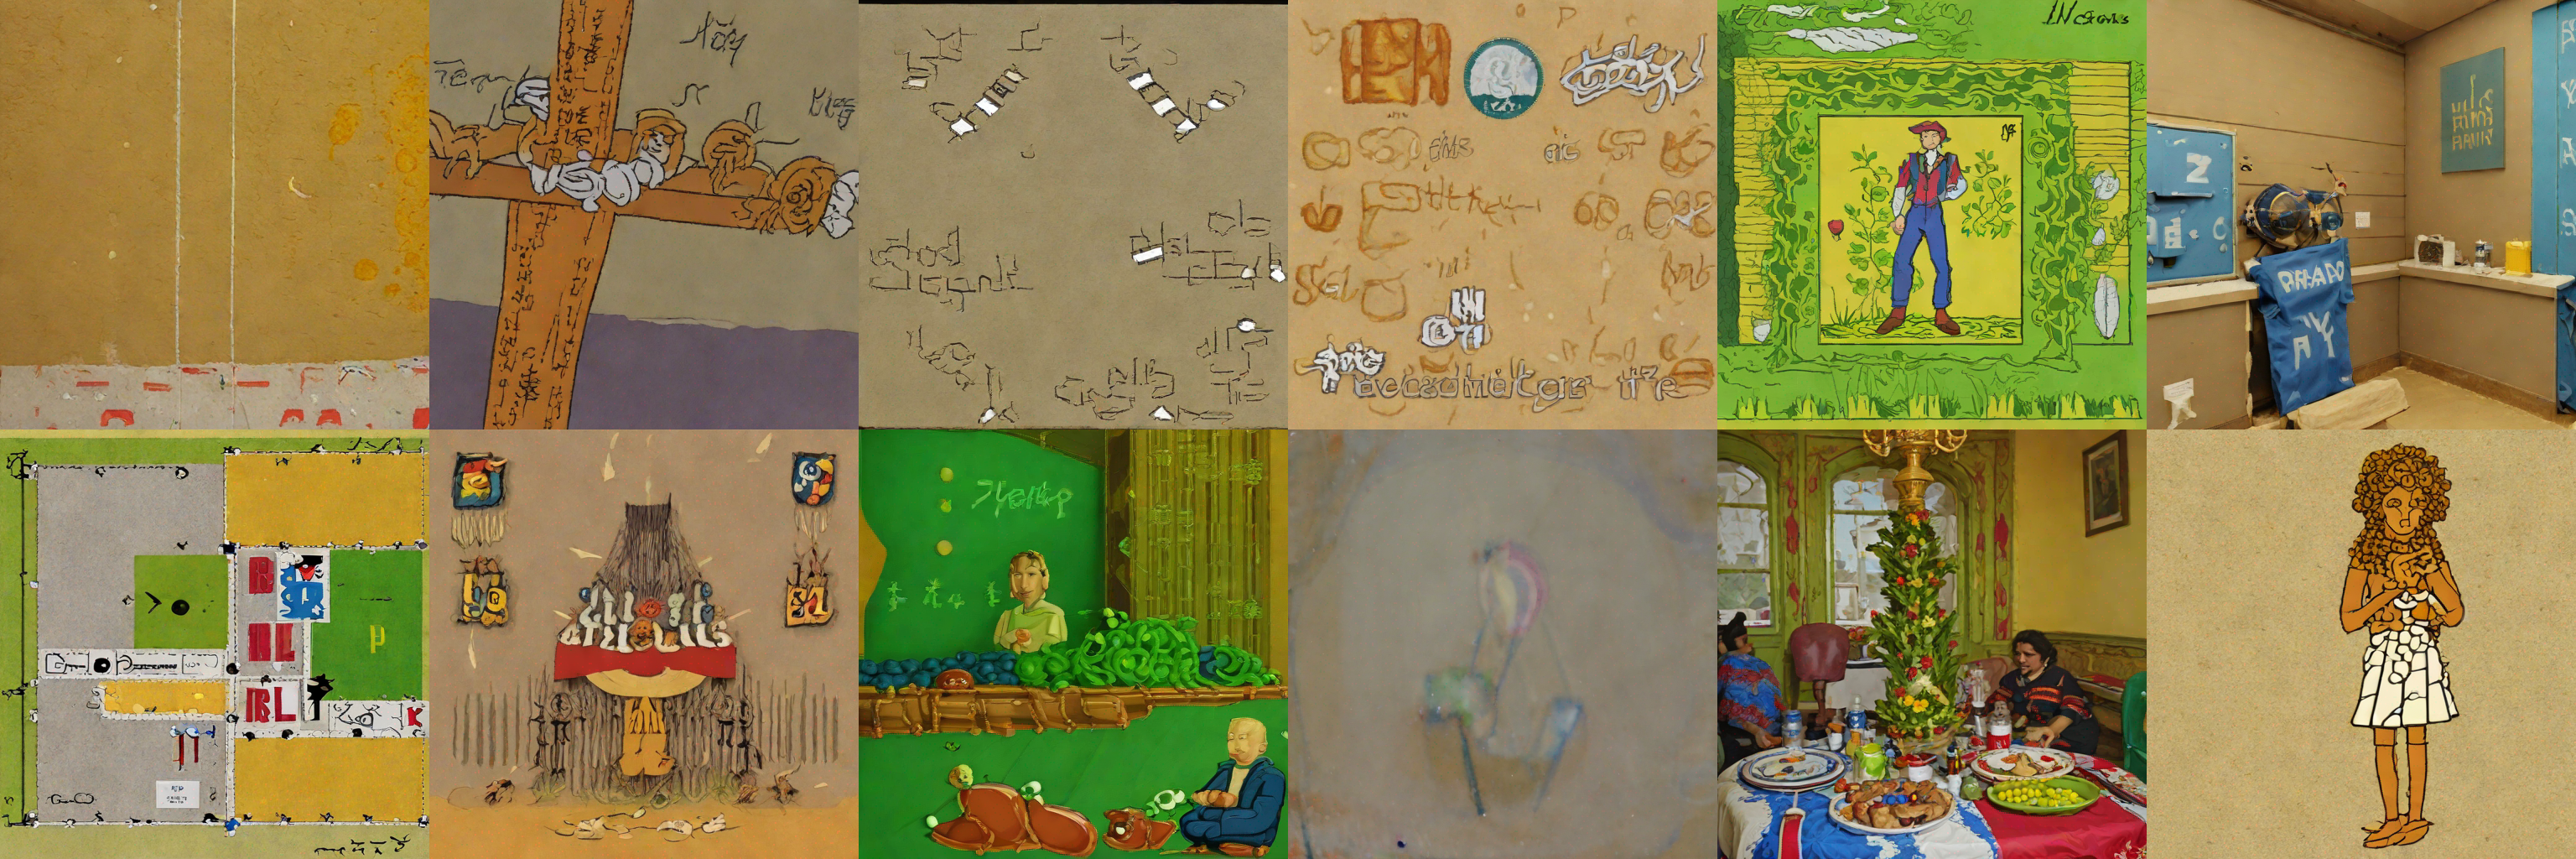

In [9]:
from diffusers.utils import make_image_grid

# Show best solution
for i, best_solution in enumerate(best_solutions):
    print(f"Best solution for epoch {i}: {best_solution.fitness}")

make_image_grid([image for solution in best_solutions for image in solution.result.images], 2, batch_size * len(best_solutions) // 2)

## Visualize the evolution

In [10]:
for gen in range(num_generations):
    create_generation_image_grid(gen, max_images=10)

In [11]:
video_loc = create_animation_from_generations(num_generations)
print(video_loc)
from IPython.display import Video
Video(filename=video_loc) # This does not work for all browsers/notebooks, set embed to true when you want to include it in the notebook (warning large file size)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 750) to (1504, 752) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


results/evolution.mp4


## Plot fitness statistics

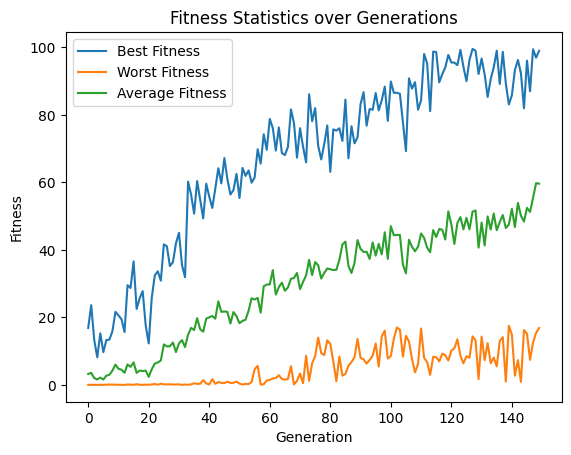

In [12]:
plot_fitness_statistics(num_generations, island_model.best_fitness, island_model.worst_fitness, island_model.avg_fitness)

In [ ]:
!jupyter nbconvert --to html ga_notebook.ipynb

### Save the run to disk

In [21]:
import pickle
import os
from datetime import datetime

os.makedirs("saved_runs", exist_ok=True)
with open(os.path.join("saved_runs", f"island_model_aesthetics_works{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"), "wb") as f:
    pickle.dump(island_model, f) 

### Load the run from disk 
Notebook and library versions should match with the saved run

In [ ]:
import pickle
import os

with open(os.path.join("saved_runs", "insert_filename"), "rb") as f:
    island_model = pickle.load(f)

## Fallback functions for when something went wrong

### Access Best Solution from Disk

In [ ]:
import os
import glob
import evolutionary_imaging.processing as ip
from PIL import Image

num_generations = 22  # Set this to the number of generations you ran (if you didn't finish)
generation_dir = os.path.join(ip.RESULTS_FOLDER, f"{num_generations}")
image_files = glob.glob(os.path.join(generation_dir, "*.png"))
image_files.sort(key=ip.fitness_filename_sorting_key, reverse=True)
print(image_files[0])
Image.open(image_files[0])

### ffmpeg is not installed, create GIF instead

In [ ]:
from evolutionary_imaging.processing import create_animation_from_generations_pil
video_loc = create_animation_from_generations_pil(num_generations)
print(video_loc)
from IPython.display import Video
Video(filename=video_loc) 